# I. Preprocessing

### 0. Ensure datasets exist in `wustlcarla/datasets` directory

In [1]:
import os
DATASETS_DIRECTORY = '../datasets/'
try:
    if not os.listdir(DATASETS_DIRECTORY):
        print("No datasets found! Use `python3 notebooks/utils/get_sample_datasets.py` to download dataset!")
    else:
        print("Datasets exist")
except FileNotFoundError as e:
    print("Directory *{}* not found".format(DATASETS_DIRECTORY))
    raise e
except Exection as e:
    raise e

Datasets exist


### 0. Check if sufficient memory is available to load data

In [2]:
import psutil
memory = float(str(psutil.virtual_memory()).split('available=')[1].split(',')[0]) / 2 ** 30
min_memory = 30.0
print("Available Memory: {0:.2f} GB".format(memory))
print("Required Memory: {} GB".format(min_memory))
if memory <= min_memory:
    print("Insufficient memory. Please wait until more memory efficient pipeline is available to run the notebook.")
else:
    print("You have sufficient memory to run this notebook.")

Available Memory: 141.10 GB
Required Memory: 30.0 GB
You have sufficient memory to run this notebook.


### 1. Imports

In [3]:
import os                                 # system commands
import sys                                # system commands
import json                               # read measurement.json files
import random                             # random lib
import numpy as np                        # numerical python lib
from PIL import Image                     # image processing lib
import matplotlib.pyplot as plt           # plotting lib
from keras.utils import Progbar           # progress bar!
from timeit import default_timer as timer # time lib
import tensorflow as tf
print(tf.__version__)

Using TensorFlow backend.


1.12.0


### 2. Set up GPU

In [4]:
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()

GPU_ID = '0'
# gpu_fraction = 0.1
config.gpu_options.visible_device_list = GPU_ID
# config.gpu_options.allow_growth = True
# config.gpu_options.per_process_gpu_memory_fraction = gpu_fraction

sess = tf.Session(config=config)

# gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction)
#config.gpu_options.per_process_gpu_memory_fraction =gpu_fraction


# config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
# config.log_device_placement = True  # to log device placement (on which device the operation ran)
#                                     (nothing gets printed in Jupyter, only if you run it standalone)
# sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

print("This model will train on GPU {}".format(GPU_ID))

This model will train on GPU 0


In [5]:
tf.test.is_gpu_available()

True

### 3. Set Dataset directories

In [6]:
DATASET_DIR = '/wustlcarla/datasets/'
TRAIN_DIR   = DATASET_DIR + 'CoILTrain'
VAL_DIR     = DATASET_DIR + 'CoILVal1'
TEST_DIR    = DATASET_DIR + 'CoILVal2'

### 4. Fetch episodes from Dataset directories

In [8]:
######## CHECK AVAILABLE DATA ########
use_default_directories = False

if use_default_directories:
    directories = [TRAIN_DIR, VAL_DIR, TEST_DIR]
else:
    directories = [TRAIN_DIR]

episode_list = []
for directory in directories:
    for item in os.listdir(directory):
        if 'episode' in item:
            episode_list.append(directory + '/' + item)

print("Total Episodes:", len(episode_list))
episode_list[:5]

Total Episodes: 20


['/wustlcarla/datasets/CoILTrain/episode_00003',
 '/wustlcarla/datasets/CoILTrain/episode_00018',
 '/wustlcarla/datasets/CoILTrain/episode_00012',
 '/wustlcarla/datasets/CoILTrain/episode_00000',
 '/wustlcarla/datasets/CoILTrain/episode_00010']

### 5. Find Image and Measurement files

In [9]:
######## FIND IMAGE AND JSON DATA FILES ########
x_data_files       = []
y_data_files       = []
x_data_files_left  = []
x_data_files_right = []

central_camera_text = 'CentralRGB_'
left_camera_text    = 'LeftRGB_'
right_camera_text   = 'RightRGB_'
measurement_text    = 'measurements_'

for ep in episode_list:
    files = os.listdir(ep)
    for file in files:
        if central_camera_text in file:
            x_data_files.append(ep + '/' + file)
        if left_camera_text in file:
            x_data_files_left.append(ep + '/' + file)
        if right_camera_text in file:
            x_data_files_right.append(ep + '/' + file)
        if measurement_text in file:
            y_data_files.append(ep + '/' + file)
            
x_data_files       = sorted(x_data_files)
x_data_files_left  = sorted(x_data_files_left)
x_data_files_right = sorted(x_data_files_right)
y_data_files       = sorted(y_data_files)

print("X length:", len(x_data_files), "| Sample:", x_data_files[0])
print("Y length:", len(y_data_files), "| Sample:", y_data_files[0])

print("X_left length:", len(x_data_files_left), "| Sample:", x_data_files_left[0])
print("X_right length:", len(x_data_files_right), "| Sample:", x_data_files_right[0])

######## FIND AND FIX MISSING DATA ########
if len(x_data_files) != len(y_data_files):
    print("\nWarning: X and Y data files do not have the same length. Applying fix!")
    x = [''.join([i.split('episode_')[1].split('/')[0], 
              i.split('CentralRGB_')[1].split('.png')[0]]) for i in x_data_files]
    y = [''.join([i.split('episode_')[1].split('/')[0], 
                  i.split('measurements_')[1].split('.json')[0]]) for i in y_data_files]
    diff = list(set(y) - set(x))
    for item in diff:
        remove_ep  = '/wustlcarla/datasets/CoILTrain/episode_' + item[:5] + '/measurements_' + item[5:] + '.json'
        y_data_files.remove(remove_ep)
        print("Removed:", remove_ep)
    print("X length:", len(x_data_files), "| Sample:", x_data_files[0])
    print("Y length:", len(y_data_files), "| Sample:", y_data_files[0])

X length: 38604 | Sample: /wustlcarla/datasets/CoILTrain/episode_00000/CentralRGB_00000.png
Y length: 38606 | Sample: /wustlcarla/datasets/CoILTrain/episode_00000/measurements_00000.json
X_left length: 38604 | Sample: /wustlcarla/datasets/CoILTrain/episode_00000/LeftRGB_00000.png
X_right length: 38604 | Sample: /wustlcarla/datasets/CoILTrain/episode_00000/RightRGB_00000.png

Removed: /wustlcarla/datasets/CoILTrain/episode_00001/measurements_01830.json
Removed: /wustlcarla/datasets/CoILTrain/episode_00000/measurements_02289.json
X length: 38604 | Sample: /wustlcarla/datasets/CoILTrain/episode_00000/CentralRGB_00000.png
Y length: 38604 | Sample: /wustlcarla/datasets/CoILTrain/episode_00000/measurements_00000.json


### 6. Load Image and Measurement Files

In [10]:
################## PROCESSING INPUT DATA ######################
FRAME_BATCH         = 6  # number of frames and respective data is clumped together
N                   = len(x_data_files) - len(x_data_files) % FRAME_BATCH # get rid of extra data that doesn't fit in batch

x_data_camera       = np.zeros((N, 88, 200, 3)).astype('uint8')
# x_data_camera_left  = np.zeros((N, 88, 200, 3)).astype('uint8')
# x_data_camera_right = np.zeros((N, 88, 200, 3)).astype('uint8')

x_data_speed        = np.zeros(N)
x_data_direction    = np.zeros(N)
    
y_steer             = np.zeros(N)
y_throttle          = np.zeros(N)
y_brake             = np.zeros(N)

stop_pedestrian     = np.zeros(N)
stop_traffic_lights = np.zeros(N)
stop_vehicle        = np.zeros(N)

pos_x               = np.zeros(N)
pos_y               = np.zeros(N)
pos_z               = np.zeros(N)

print("Extracting Center Camera images ...")
start   = timer()
progbar = Progbar(target=N, verbose=1)
for index, image in enumerate(x_data_files):
    if index < N:
        x_data_camera[index] = np.array(Image.open(image)).astype('uint8')
        progbar.update(index)
    else:
        break
end = timer()
print("\nExtracted Center Camera images (in {:.2f} seconds).".format(end-start))    

# print("Extracting Right Camera images ...")
# start   = timer()
# progbar = Progbar(target=N, verbose=1)
# for index, image in enumerate(x_data_files_right):
#     if index < N:
#         x_data_camera_right[index] = np.array(Image.open(image)).astype('uint8')
#         progbar.update(index)
#     else:
#         break
# end = timer()
# print("\nExtracted Right Camera images (in {:.2f} seconds).".format(end-start)) 

# print("Extracting Left Camera images ...")
# start   = timer()
# progbar = Progbar(target=N, verbose=1)
# for index, image in enumerate(x_data_files_left):
#     if index < N:
#         x_data_camera_left[index] = np.array(Image.open(image)).astype('uint8')
#         progbar.update(index)
#     else:
#         break
# end = timer()
# print("\nExtracted Left Camera images (in {:.2f} seconds).".format(end-start)) 

print("Extracting measurements ...")   
start   = timer()
progbar = Progbar(target=N, verbose=1)
for index, jsn in enumerate(y_data_files):
    if index < N:
        with open(jsn) as f:
            measurements = json.loads(f.read())
        x_data_direction[index] = measurements['directions']
        y_steer[index]          = measurements['steer']
        y_throttle[index]       = measurements['throttle']
        y_brake[index]          = measurements['brake']
        
        stop_pedestrian[index]     = measurements['stop_pedestrian']      
        stop_traffic_lights[index] = measurements['stop_traffic_lights'] 
        stop_vehicle[index]        = measurements['stop_vehicle'] 
        
        pos_x[index] = measurements['playerMeasurements']['transform']['location']['x']
        pos_y[index] = measurements['playerMeasurements']['transform']['location']['y']
        pos_z[index] = measurements['playerMeasurements']['transform']['location']['z']
        try:
            x_data_speed[index] = measurements['playerMeasurements']['forwardSpeed']        
        except:
            x_data_speed[index] = 0 # if forward speed not found, use speed = 0
        progbar.update(index)
    else:
        break 
y_data = np.array([y_steer, y_throttle, y_brake]).T
del y_steer, y_throttle, y_brake
end = timer()


print("\nExtracted measurements (in {:.2f} seconds).".format(end-start))    
print("X:", x_data_camera.shape, x_data_direction.shape, x_data_speed.shape)
print("Y (steer, throttle, brake):", y_data.shape)

Extracting Center Camera images ...
38603/38604 [============================>.] - ETA: 0s
Extracted Center Camera images (in 43.83 seconds).
Extracting measurements ...
38590/38604 [============================>.] - ETA: 0s
Extracted measurements (in 111.82 seconds).
X: (38604, 88, 200, 3) (38604,) (38604,)
Y (steer, throttle, brake): (38604, 3)


### Directions:
- 0 - void
- 2 - follow lane
- 3 - left
- 4 - right
- 5 - straight

### 7. Normalize speed & change void directions to lanefollow

In [11]:
############# CHANGE VOID DIRECTION TO LANE FOLLOW #############
x_data_direction[x_data_direction == 0] = 2

# ############# NORMALIZE SPEED #############
if np.max(x_data_speed) > 1:
    x_data_speed = x_data_speed / 12
else:
    print("Speeds may already been normalzied!")
x_data_speed[x_data_speed < 0] = 0
print("Speed (max, min)", max(x_data_speed), min(x_data_speed))

############# NORMALIZE STEER #############
# y_data[:, 0][y_data[:, 0] > 0.] = y_data[:, 0][y_data[:, 0] > 0.] / (np.max(y_data[:, 0]))
# y_data[:, 0][y_data[:, 0] < 0.] = y_data[:, 0][y_data[:, 0] < 0.] / (-np.min(y_data[:, 0]))
print("Steer (max, min)", max(y_data[:, 0]), min(y_data[:, 0]))

Speed (max, min) 0.854419469833374 0.0
Steer (max, min) 0.6003490090370178 -0.3192621171474457


### Some visualizations of dataset

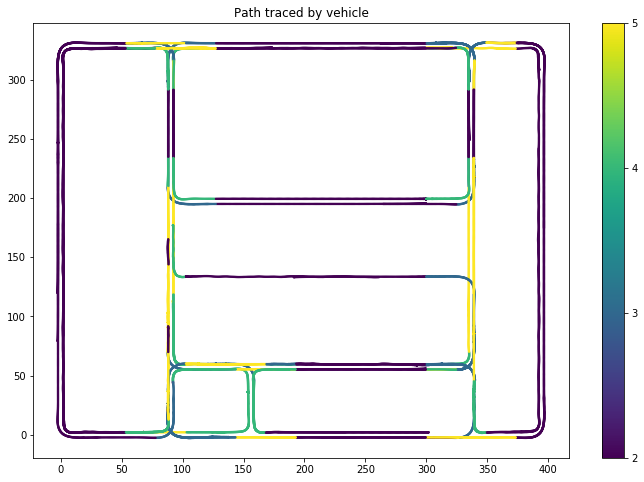

In [13]:
############# VISUALIZE VEHICLE PATH #############
import matplotlib as mpl
fig, ax = plt.subplots(figsize=(12, 8))
plt.scatter(pos_x, pos_y, 
           c=x_data_direction, cmap='viridis', s=2)
plt.title('Path traced by vehicle')
plt.colorbar(ticks=[2, 3, 4, 5])
plt.show()

Text(0.5,1,'Brake Histogram')

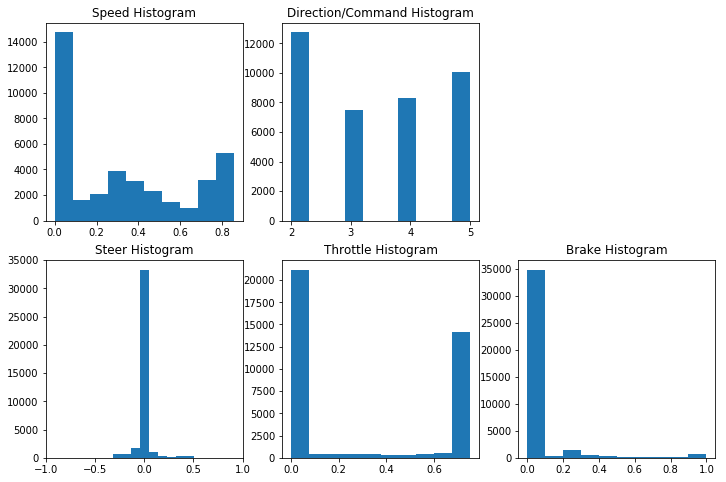

In [14]:
############# VISUALIZATION OF DATA DISTRIBUTION #############

fig, ax = plt.subplots(figsize=(12, 8))

plt.subplot(2, 3, 1)
plt.hist(x_data_speed, 10)
plt.title('Speed Histogram')

plt.subplot(2, 3, 2)
plt.hist(x_data_direction)
plt.title('Direction/Command Histogram')

plt.subplot(2, 3, 4)
plt.hist(y_data[:,0], 10)
plt.xlim([-1 ,1])
plt.title('Steer Histogram')

plt.subplot(2, 3, 5)
plt.hist(y_data[:,1], 10)
plt.title('Throttle Histogram')

plt.subplot(2, 3, 6)
plt.hist(y_data[:,2], 10)
plt.title('Brake Histogram')

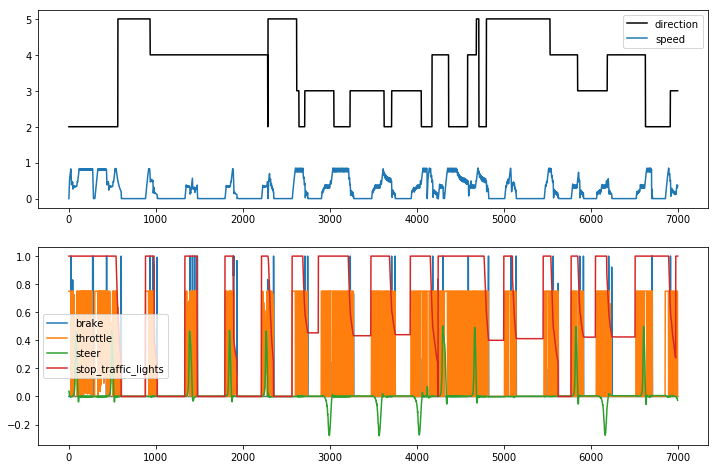

In [15]:
################## VISUALIZE CONTROL COMMANDS ######################
range_start, range_end = 0, 7000

fig, ax = plt.subplots(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(x_data_direction[range_start:range_end], '-k', label='direction')
plt.plot(x_data_speed[range_start:range_end], label='speed')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(y_data[range_start:range_end,2], label='brake')
plt.plot(y_data[range_start:range_end,1], label='throttle')
plt.plot(y_data[range_start:range_end,0], label='steer')
# plt.plot(x_data_direction[range_start:range_end], '-k', label='direction') 
plt.plot(stop_traffic_lights[range_start:range_end], label='stop_traffic_lights')
plt.legend()

### 8. Filter data (remove red traffic light, and other options)

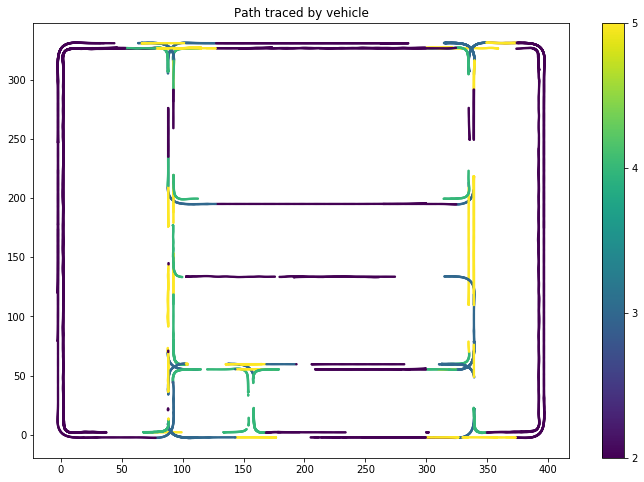

In [16]:
################## DATA PRUNING ######################
"""
- Remove hazards
"""
DIRECTION = None
# None - No direction filter
# 2 - follow lane
# 3 - left
# 4 - right
# 5 - straight

filters = {
    'red_traffic_light': stop_traffic_lights==1,
    'vehicle_ahead': stop_vehicle==1,
    'pedestrian_ahead': stop_pedestrian==1
}
lane_follow_filter = np.logical_and(filters['vehicle_ahead'], filters['red_traffic_light'])
lane_follow_filter = np.logical_and(lane_follow_filter, filters['pedestrian_ahead'])

if DIRECTION is not None:
    filters['direction'] = x_data_direction==DIRECTION
    lane_follow_filter = np.logical_and(lane_follow_filter, filters['direction'])

if len(lane_follow_filter) == len(x_data_camera):
    x_data_camera = x_data_camera[lane_follow_filter]
    # x_data_camera_left = x_data_camera_left[lane_follow_filter]
    # x_data_camera_right = x_data_camera_right[lane_follow_filter]
    x_data_speed = x_data_speed[lane_follow_filter]
    x_data_direction = x_data_direction[lane_follow_filter]
    y_data = y_data[lane_follow_filter]

    pos_x = pos_x[lane_follow_filter]
    pos_y = pos_y[lane_follow_filter]
    pos_z = pos_z[lane_follow_filter]

############# VISUALIZE VEHICLE PATH #############
import matplotlib as mpl
fig, ax = plt.subplots(figsize=(12, 8))
plt.scatter(pos_x, pos_y, 
           c=x_data_direction, cmap='viridis', s=2)
plt.title('Path traced by vehicle')
plt.colorbar(ticks=[2, 3, 4, 5])
plt.show()

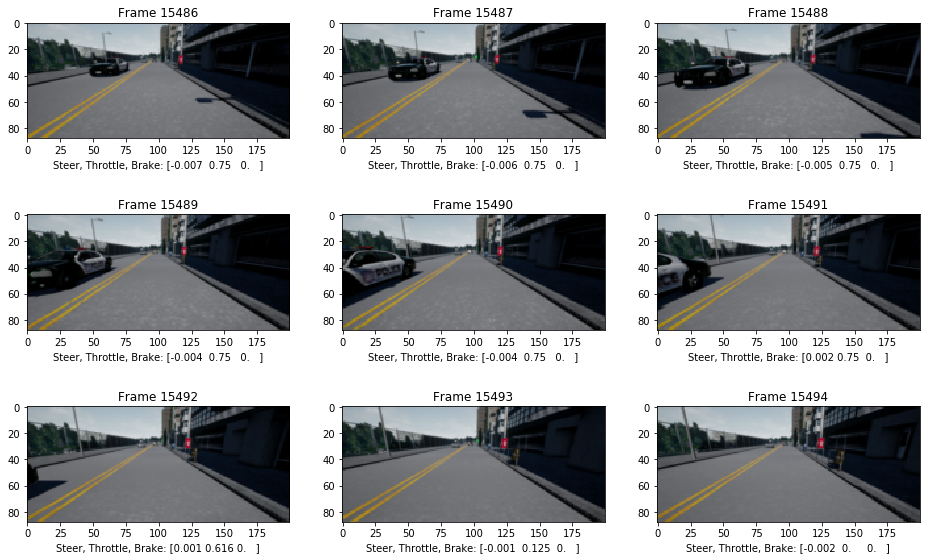

In [17]:
############# VISUALIZE SOME CAMERA FRAMES #############
fig, ax = plt.subplots(figsize=(16, 10))
sample = np.random.randint(len(x_data_camera)-10)
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_data_camera[i+sample])
    plt.title("Frame " + str(i+sample))
    plt.xlabel("Steer, Throttle, Brake: "+ str(np.round(y_data[i+sample], 3)))

### 9. Split data into Train and Test sets

In [18]:
############# SPLIT DATA TO TRAINING AND TEST SETS #############
from sklearn.model_selection import ShuffleSplit, train_test_split

SPLIT_RATIO = 0.8
SHUFFLE = False

try:
    if not SHUFFLE:
        split = int(len(y_data) * SPLIT_RATIO)
        x_train_camera, x_test_camera = x_data_camera[:split], x_data_camera[split+1:]
        x_train_speed, x_test_speed = x_data_speed[:split], x_data_speed[split+1:]
        x_train_direction, x_test_direction = x_data_direction[:split], x_data_direction[split+1:]
        y_train, y_test = y_data[:split], y_data[split+1:]
    else:
        indices = np.arange(len(y_data))
        x_train_ind, x_test_ind, y_train_ind, y_test_ind = train_test_split(indices, indices, test_size=(1-SPLIT_RATIO))
        
        x_train_camera, x_test_camera = x_data_camera[x_train_ind, :, :, 0:3], x_data_camera[x_test_ind, :, :, 0:3]
        x_train_speed, x_test_speed  = x_data_speed[x_train_ind], x_data_speed[x_test_ind]
        x_train_direction, x_test_direction = x_data_direction[x_train_ind], x_data_direction[x_test_ind]
        y_train, y_test = y_data[y_train_ind, :], y_data[y_test_ind, :]
        
        del indices, x_train_ind, x_test_ind, y_train_ind, y_test_ind
except Error as E:
    print(E)
    print("x_data_* and y_data values are empty. Using previously stored values.")
    
print("Train Shape | x_train_camera:", x_train_camera.shape, "\t| x_train_speed:", x_train_speed.shape,
      "\t| y_train:", y_train.shape)
print(" Test Shape | x_test_camera:", x_test_camera.shape, "\t| x_test_speed:", x_test_speed.shape, 
      "\t| y_test:", y_test.shape)

Train Shape | x_train_camera: (12913, 88, 200, 3) 	| x_train_speed: (12913,) 	| y_train: (12913, 3)
 Test Shape | x_test_camera: (3228, 88, 200, 3) 	| x_test_speed: (3228,) 	| y_test: (3228, 3)


### 10. Normalize Image data

In [19]:
############# PREPROCESS DATA #############
img_rows, img_cols, img_chnls = 88, 200, 3 # input image dimensions

if np.max(np.max(x_train_camera)) > 1:
    x_train_camera = x_train_camera.reshape(x_train_camera.shape[0], img_rows, img_cols, img_chnls)
    x_test_camera  = x_test_camera.reshape(x_test_camera.shape[0], img_rows, img_cols, img_chnls)
    x_train_camera = x_train_camera.astype('float32')
    x_test_camera = x_test_camera.astype('float32')
    x_train_camera /= 255
    x_test_camera /= 255
else:
    print("Images have already been normalized.")
    
print('x_train shape:', x_train_camera.shape)
print(x_train_camera.shape[0], 'train samples')
print(x_test_camera.shape[0], 'test samples')

x_train shape: (12913, 88, 200, 3)
12913 train samples
3228 test samples


# II. Training

### 11. Set up TensorFlow Network Architecture

In [20]:
# Training Parameters
learning_rate = 0.001
num_steps = 10000
batch_size = 100

# Network Parameters
output_size = 1 # total outputs
dropout = 0.25 # Dropout, probability to drop a unit

In [21]:
# Create the neural network
def wustlcarla_net(x_dict, output_size, dropout, reuse, is_training):
    
    # Define a scope for reusing the variables
    with tf.variable_scope('wustlcarlaNet', reuse=reuse):
        # TF Estimator input is a dict, in case of multiple inputs
        x_image = x_dict['images']
        x_speed = x_dict['speed']
        x_direction = x_dict['direction']

        # Data input is a 1-D vector of 52800 features (88*200*3 pixels)
        # Reshape to match picture format [Height x Width x Channel]
        # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
        x = tf.reshape(x_image, shape=[-1, 88, 200, 3])

        # Convolution Layer with 32 filters and a kernel size of 5
        conv1 = tf.layers.conv2d(x, 32, 5, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv1 = tf.layers.max_pooling2d(conv1, 2, 2)

        # Convolution Layer with 64 filters and a kernel size of 3
        conv2 = tf.layers.conv2d(conv1, 64, 3, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv2 = tf.layers.max_pooling2d(conv2, 2, 2)

        # Flatten the data to a 1-D vector for the fully connected layer
        fc1 = tf.contrib.layers.flatten(conv2)

        # Fully connected layer (in tf contrib folder for now)
        fc1 = tf.layers.dense(fc1, 1024)
        # Apply Dropout (if is_training is False, dropout is not applied)
        fc1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)
        
        fc3 = tf.layers.dense(x_speed, 128, activation='relu')
        fc3 = tf.layers.dropout(fc3, rate=0.5, training=is_training)
        
        fc4 = tf.layers.dense(fc3, 128, activation='relu')
        fc4 = tf.layers.dropout(fc4, rate=0.5, training=is_training)
        
        concat = tf.concat([fc1, fc4], 1)
        concat = tf.layers.dense(concat, 128, activation='relu')
        
        # left branch
        left = tf.layers.dense(concat, 256, activation='relu')
        left = tf.layers.dropout(left, rate=0.5, training=is_training)
        left = tf.layers.dense(left, 256, activation='relu')
        out_left =  tf.layers.dense(left, output_size)
        
        # right branch
        right = tf.layers.dense(concat, 256, activation='relu')
        right = tf.layers.dropout(right, rate=0.5, training=is_training)
        right = tf.layers.dense(right, 256, activation='relu')
        out_right =  tf.layers.dense(right, output_size)
             
        # straight branch
        straight = tf.layers.dense(concat, 256, activation='relu')
        straight = tf.layers.dropout(straight, rate=0.5, training=is_training)
        straight = tf.layers.dense(straight, 256, activation='relu')
        out_straight =  tf.layers.dense(straight, output_size)
             
        # lane follow branch
        lanefollow = tf.layers.dense(concat, 256, activation='relu')
        lanefollow = tf.layers.dropout(lanefollow, rate=0.5, training=is_training)
        lanefollow = tf.layers.dense(lanefollow, 256, activation='relu')
        out_lanefollow = tf.layers.dense(lanefollow, output_size)
        
        # Output layer, control prediction
        out = tf.where(tf.equal(x_direction,2.0), out_lanefollow,
                (tf.where(tf.equal(x_direction, 3.0),  out_left, 
                (tf.where(tf.equal(x_direction, 4.0),  out_right, out_straight)))))

    return out

### Not used (requires fix) wustlcarla_net_BASELINE -> copy of our Keras model

In [ ]:
# Create the neural network
def wustlcarla_net_BASELINE(x_dict, output_size, dropout, reuse, is_training):
    
    # Define a scope for reusing the variables
    with tf.variable_scope('WustlCarlaNet', reuse=reuse):
        # TF Estimator input is a dict, in case of multiple inputs
        x_image = x_dict['images']
        x_speed = x_dict['speed']
        
        # MNIST data input is a 1-D vector of 784 features (28*28 pixels)
        # Reshape to match picture format [Height x Width x Channel]
        # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
        x = tf.reshape(x_image, shape=[-1, 88, 200, 3])

        # Convolution Layer with 32 filters and a kernel size of 5
        conv1 = tf.layers.conv2d(x, 32, 5, strides=1, padding='valid', use_bias=False)
#         conv1 = tf.layers.max_pooling2d(conv1, 2, 2)
        conv1 = tf.layers.batch_normalization(conv1)
        conv1 = tf.nn.relu(conv1)
        
        # Convolution Layer with 32 filters and a kernel size of 3
        conv2 = tf.layers.conv2d(conv1, 32, 3, strides=1, padding='valid', use_bias=False)
#         conv2 = tf.layers.max_pooling2d(conv2, 2, 2)
        conv2 = tf.layers.batch_normalization(conv2)
        conv2 = tf.nn.relu(conv2)
        
        # Convolution Layer with 64 filters and a kernel size of 3
        conv3 = tf.layers.conv2d(conv2, 64, 3, strides=2, padding='valid', use_bias=False)
#         conv3 = tf.layers.max_pooling2d(conv3, 2, 2)
        conv3 = tf.layers.batch_normalization(conv3)
        conv3 = tf.nn.relu(conv3)
        
        # Convolution Layer with 64 filters and a kernel size of 3
        conv4 = tf.layers.conv2d(conv3, 64, 3, strides=1, padding='valid', use_bias=False)
#         conv4 = tf.layers.max_pooling2d(conv4, 2, 2)
        conv4 = tf.layers.batch_normalization(conv4)
        conv4 = tf.nn.relu(conv4)
        
        # Convolution Layer with 128 filters and a kernel size of 3
        conv5 = tf.layers.conv2d(conv4, 128, 3, strides=2, padding='valid', use_bias=False)
#         conv5 = tf.layers.max_pooling2d(conv5, 2, 2)
        conv5 = tf.layers.batch_normalization(conv5)
        conv5 = tf.nn.relu(conv5)

        # Convolution Layer with 128 filters and a kernel size of 3
        conv6 = tf.layers.conv2d(conv5, 128, 3, strides=1, padding='valid', use_bias=False)
#         conv6 = tf.layers.max_pooling2d(conv6, 2, 2)
        conv6 = tf.layers.batch_normalization(conv6)
        conv6 = tf.nn.relu(conv6)
        
        # Convolution Layer with 128 filters and a kernel size of 3
        conv7 = tf.layers.conv2d(conv6, 256, 3, strides=1, padding='valid', use_bias=False, activation=tf.nn.relu)
# #         conv7 = tf.layers.max_pooling2d(conv7, 2, 2)
        conv7 = tf.layers.batch_normalization(conv7)
        conv7 = tf.nn.relu(conv7)
        
#         # Convolution Layer with 128 filters and a kernel size of 3
        conv8 = tf.layers.conv2d(conv7, 256, 3, strides=1, padding='valid', use_bias=False, activation=tf.nn.relu)
#         conv8 = tf.layers.max_pooling2d(conv8, 2, 2)
        conv8 = tf.layers.batch_normalization(conv8)
        conv8 = tf.nn.relu(conv8)

        # Flatten the data to a 1-D vector for the fully connected layer
        fc1 = tf.contrib.layers.flatten(conv8)

        fc1 = tf.layers.dense(fc1, 512)
        # Apply Dropout (if is_training is False, dropout is not applied)
        fc1 = tf.layers.dropout(fc1, rate=0.3, training=is_training)

        fc2 = tf.layers.dense(fc1, 512, activation='relu')
        fc2 = tf.layers.dropout(fc2, rate=0.3, training=is_training)
        
        fc3 = tf.layers.dense(x_speed, 128, activation='relu')
        fc3 = tf.layers.dropout(fc3, rate=0.3, training=is_training)
        
        fc4 = tf.layers.dense(fc3, 128, activation='relu')
        fc4 = tf.layers.dropout(fc4, rate=0.3, training=is_training)
        
        concat = tf.concat([fc2, fc4], 1)
        
        fc5 = tf.layers.dense(concat, 512, activation='relu')
        fc5 = tf.layers.dropout(fc5, rate=0.3, training=is_training)
        
        fc6 = tf.layers.dense(fc5, 256, activation='relu')
        fc6 = tf.layers.dropout(fc6, rate=0.3, training=is_training)
        
        fc7 = tf.layers.dense(fc6, 256, activation='relu')
        
        # Output layer, class prediction
        out = tf.layers.dense(fc7, output_size, activation='linear')

    return out

In [22]:
# Define the model function (following TF Estimator Template)
def model_fn(features, labels, mode):
    
    # Build the neural network
    # Because Dropout have different behavior at training and prediction time, we
    # need to create 2 distinct computation graphs that still share the same weights.
    output_train = wustlcarla_net(features, output_size, dropout, reuse=False, is_training=True)
    output_test = wustlcarla_net(features, output_size, dropout, reuse=True, is_training=False)
    
    # If prediction mode, early return
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=output_test) 
        
    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.losses.absolute_difference(
        output_train, labels))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
    
    # Evaluate the accuracy of the model
    acc_op = tf.metrics.mean_absolute_error(labels=labels, predictions=output_test)
    # TF Estimators requires to return a EstimatorSpec, that specify
    # the different ops for training, evaluating, ...
    estim_specs = tf.estimator.EstimatorSpec(
      mode=mode,
      predictions=output_test,
      loss=loss_op,
      train_op=train_op,
      eval_metric_ops={'mae': acc_op})

    return estim_specs

In [23]:
# Build the Estimator
model = tf.estimator.Estimator(model_fn, model_dir="./logs/tf_logs_{}/".format(0))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_device_fn': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f692c1e8fd0>, '_task_id': 0, '_eval_distribute': None, '_evaluation_master': '', '_log_step_count_steps': 100, '_service': None, '_tf_random_seed': None, '_model_dir': './logs/tf_logs_0/', '_is_chief': True, '_global_id_in_cluster': 0, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_protocol': None, '_num_worker_replicas': 1, '_save_summary_steps': 100, '_task_type': 'worker', '_master': '', '_train_distribute': None, '_num_ps_replicas': 0, '_save_checkpoints_steps': None, '_experimental_distribute': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
}


In [24]:
# Define the input function for training
y = y_train[:, 0].astype('float32').reshape(-1,1)
train_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': x_train_camera, 'speed':x_train_speed.reshape(-1, 1).astype('float32'), 
       'direction' : x_train_direction.reshape(-1,1).astype('float32') }, y=y,
    batch_size=batch_size, num_epochs=None, shuffle=True)

# Define the input function for evaluating
y_eval = y_test[:, 0].astype('float32').reshape(-1,1)
test_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': x_test_camera, 'speed':x_test_speed.astype('float32').reshape(-1,1),
      'direction' : x_test_direction.reshape(-1,1).astype('float32') }, y=y_eval,
    batch_size=batch_size, shuffle=False)

### Training n Epochs

In [26]:
num_epochs = 10
num_steps = len(x_train_camera) // batch_size

for epoch in range(1, num_epochs + 1):
    # Train the Model
    model.train(train_fn, steps=num_steps)
    # Use the Estimator 'evaluate' method
    model.evaluate(test_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./logs/tf_logs_0/model.ckpt-1290
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1290 into ./logs/tf_logs_0/model.ckpt.
INFO:tensorflow:loss = 0.007976411, step = 1290
INFO:tensorflow:global_step/sec: 14.0906
INFO:tensorflow:loss = 0.0153734395, step = 1390 (7.102 sec)
INFO:tensorflow:Saving checkpoints for 1419 into ./logs/tf_logs_0/model.ckpt.
INFO:tensorflow:Loss for final step: 0.008880585.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-05-08-14:33:38
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./logs/tf_logs_0/model.ckpt-1419
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:

KeyboardInterrupt: 

### 18. Predict and Plot

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./logs/tf_logs_0/model.ckpt-2064
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


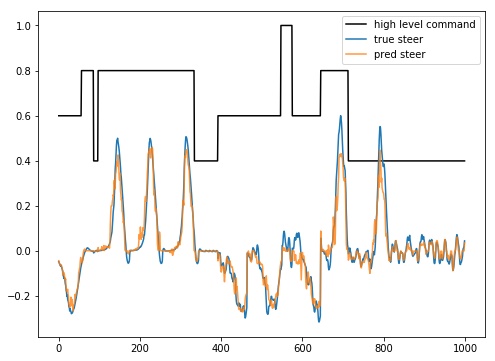

In [28]:
outs = []
for i in model.predict(test_fn):
    outs.append(i[0])
fig, ax = plt.subplots(figsize=(8, 6))
    
plt.plot(x_test_direction[:1000]/5, 'k', label='high level command')
plt.plot(y_test[:1000, 0], label='true steer')
plt.plot(outs[:1000], alpha=0.8, label='pred steer')
plt.legend()